# Ice Surface Temperatures (IST) from Sentinel-3a SLSTR

In [21]:
# Importing libraries:
from pathlib import Path
import numpy as np
import os 
import glob
from netCDF4 import Dataset
import matplotlib.pyplot as plt

## Importing and looking at the L1 SLSTR TIR data files

#### SLSTR Level-1 data products:

The SLSTR Level-1 observation mode products consist of full resolution, geolocated, co-located nadir and along track view, Top of Atmosphere (TOA) brightness temperatures (in the case of thermal IR channels) or radiances (in the case of visible, NIR and SWIR channels) from all SLSTR channels. It also contains quality flags, pixel classification information and meteorological annotations.

All of these parameters are contained in a set of netCDF files, gathered into a single package called SL_1_RBT, which can be downloaded at: https://browser.dataspace.copernicus.eu/

Note that the name of each netCDF file provides information about it's content. The suffix of each filename is associated with the selected grid:

- "an" and "ao" refer to the 500 m grid, stripe A, respectively for nadir view (n) and oblique view (o)
- "bn" and "bo" refer to the 500 m grid, stripe B
- "in" and "io" refer to the 1 km grid
- "fn" and "fo" refer to the F1 channel 1 km grid
- "tx/n/o" refer to the tie-point grid for agnostic/nadir and oblique view

In addition, when the file is associated to a specific SLSTR channel, the filename is given a specific prefix, indicated by the following table.

<img src="slstr_prefixes.png">

#### We will here look at Level-1 data from a SLSTR scene from Sentinel-3A obtained which are in the directory.

In [22]:
basedir  = os.path.basename(glob.glob('*.SEN3')[0]) #'S3A_SL_1_RBT____20220516T003413_20220516T003713_20220517T095135_0180_085_202_1080_PS1_O_NT_004.SEN3')
print(basedir)

S3A_SL_1_RBT____20250526T010326_20250526T010626_20250526T033238_0179_126_188_1260_PS1_O_NR_004.SEN3


## Question when is the scene taken?
dd/mm/yyyy

## When is the file processed?
dd/mm/yyyy

## Now we start working with the data

The file contain brightness temperatures (BT) and radiances at various bands. Below we get the 1km gridded data files for the three "normal" TIR channels:

In [23]:
files = glob.glob(basedir+os.sep+'S*_BT_*i*.nc')
for ff in files:
    #printing the file name containing the brightness temperature data:
    print(ff)

S3A_SL_1_RBT____20250526T010326_20250526T010626_20250526T033238_0179_126_188_1260_PS1_O_NR_004.SEN3\S7_BT_in.nc
S3A_SL_1_RBT____20250526T010326_20250526T010626_20250526T033238_0179_126_188_1260_PS1_O_NR_004.SEN3\S7_BT_io.nc
S3A_SL_1_RBT____20250526T010326_20250526T010626_20250526T033238_0179_126_188_1260_PS1_O_NR_004.SEN3\S8_BT_in.nc
S3A_SL_1_RBT____20250526T010326_20250526T010626_20250526T033238_0179_126_188_1260_PS1_O_NR_004.SEN3\S8_BT_io.nc
S3A_SL_1_RBT____20250526T010326_20250526T010626_20250526T033238_0179_126_188_1260_PS1_O_NR_004.SEN3\S9_BT_in.nc
S3A_SL_1_RBT____20250526T010326_20250526T010626_20250526T033238_0179_126_188_1260_PS1_O_NR_004.SEN3\S9_BT_io.nc


For each channel, we have data from the nadir (n) and the oblique (o) views

![title](italy.jpeg)

![title](Coverage.png)

#### Getting variable names and attributes in the SLTSR BT datafiles:

In [24]:
dummyFile = files[0] # Looking at the first datafile

with Dataset(dummyFile) as src: 
    # Each datafile contains multiple bands
    for band, variable in src.variables.items():
        print('------' + band + '------')
        
        if "_BT_in" in band:
            bandName = band 
            # Printing the attributes of the BT_in variables:
            for attrname in variable.ncattrs():
                print("{} -- {}".format(attrname, getattr(variable, attrname)))        

------S7_BT_in------
_FillValue -- -32768
add_offset -- 283.73
long_name -- Gridded pixel brightness temperature for channel S7 (1km TIR grid, nadir view)
scale_factor -- 0.01
standard_name -- toa_brightness_temperature
units -- K
------S7_BT_orphan_in------
------S7_exception_in------
------S7_exception_orphan_in------


#### Getting the data for the given BT channel: 

In [25]:
# example of getting the data from a specific band into a numpy array:
data = Dataset(dummyFile)
data.set_auto_mask(False)
bandData = data.variables[bandName][:]
data.close()

#### Now visualize the recorded brightness temperature in this channel:

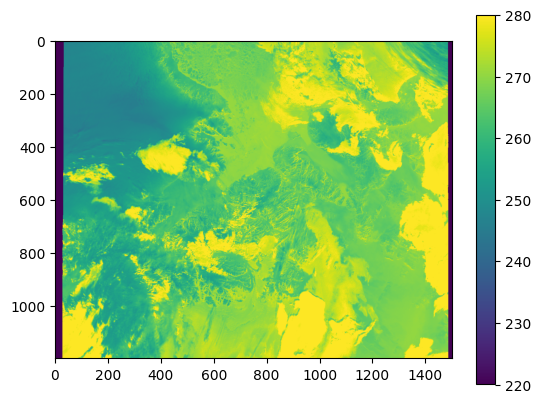

In [26]:
plt.figure()
plt.imshow(bandData, vmin=220, vmax=280)
plt.colorbar()
plt.show()

## Geolocation of the image
First we need to get the position of the nadir image, which can be found in the "geodetic"-files. In the following we use the "in" for the nadir image.   

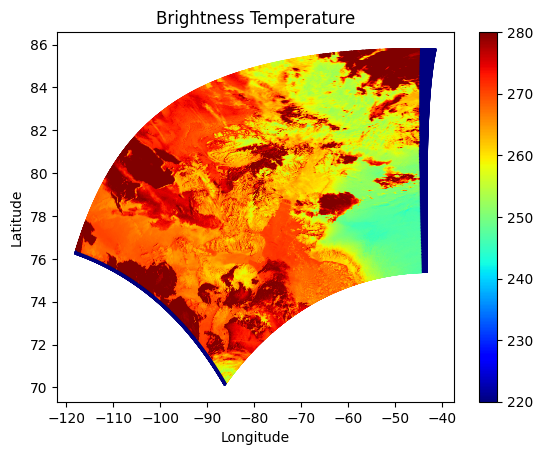

In [27]:
# Load data:
data = Dataset(basedir+os.sep+'geodetic_in.nc')
data.set_auto_mask(False)
lat_in = data.variables['latitude_in'][:]
lon_in = data.variables['longitude_in'][:]
data.close()

plt.figure()
plt.scatter(lon_in, lat_in, s=0.1, c=bandData.flatten(), cmap='jet', vmin=220, vmax=280)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Brightness Temperature')
plt.show()

## Algorithms for deriving the IST:

Multiple formulations of the IST retrievals can be found in the literature. We will here look at two formulations found to be appropriate for SLSTR when applied to sea ice in the Northern Hemisphere (SLSTR IST ATBD, Dybkjær & Eastwood, 2021). One is a traditional (single-view) split-window algorithm (IST2), while the other is a single-channel/dual-view algorithm. They are both formed as a multiple linear regression of Tbs at two of the spectral bands, namely those with wavelengths of 11 and 12 microns, here denoted as Tb11 and Tb12, and one also include the scan angle, $\theta$. 

The two algorithms are described below:

<img src="IST_algorithms.png">

Their coefficients are given in the table below:

<img src="IST_coefficients.png">

## Todays exercise:
1. Find the geographical area covered by the datafile, e.g., plot the two view angels on a map.  
2. Import the relevant bands for estimating IST in this region
3. Implement and compare the results from the two IST algorithms given above
4. Discuss the pro and cons of the two algorithms
5. Discuss the shortcomings of the exercise in terms of properly producing IST maps for this region

### Q1: Let's have a look at the geographical location of our area


You may for instance download and use the cartopy toolbox to plot one of the BT channels using geographical coordinates. The data is raster data, but depending on the geographical projection, it may be quicker to plot it as a scatter plot using the command plt.scatter(). You may add coastlines with the ax.coastlines() command.

Q1.1: Do land or marine areas show the coldest brightness temperatures? Is it what you expect? 


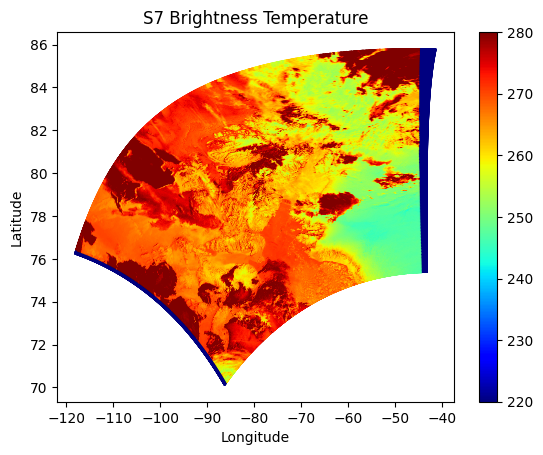

In [28]:
s7_BT_path = basedir + os.sep + 'S7_BT_in.nc'
BT_data = Dataset(s7_BT_path)
BT_data.set_auto_mask(False)
BT_in = BT_data.variables['S7_BT_in'][:]
BT_data.close()

geo_data = Dataset(basedir+os.sep+'geodetic_in.nc')
geo_data.set_auto_mask(False)
lat_in = geo_data.variables['latitude_in'][:]
lon_in = geo_data.variables['longitude_in'][:]
geo_data.close()

plt.figure()
plt.scatter(lon_in, lat_in, s=0.1, c=BT_in.flatten(), cmap='jet', vmin=220, vmax=280)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('S7 Brightness Temperature')
plt.show()





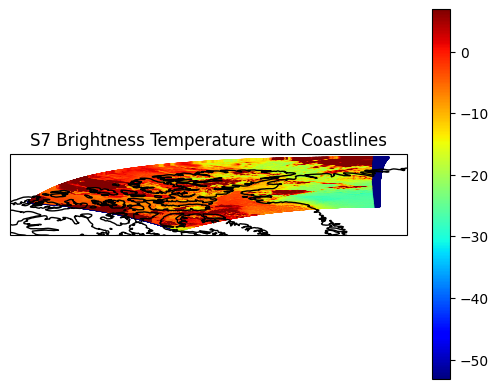

In [29]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
sc = ax.scatter(lon_in, lat_in, s=0.1, c=BT_in.flatten()-273.15, cmap='jet', vmin=220-273.15, vmax=280-273.15, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax)
ax.coastlines()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('S7 Brightness Temperature with Coastlines')
plt.show()


Q1.2: Do you have different surface types in the image and how does that relate the useability of the algorithms. 

Q1.3: Should we download another image, or what is the reason for continueing the work with the current image? (data can be downloaded at: https://browser.dataspace.copernicus.eu/)

### Q2: Import the relevant spectral bands etc. for estimating the IST using the two algorithms

Q2.1: Get the BT data for relavant bands. 

In [30]:
# load the data for 11 and 12 micron bands (S8 and S9) nadir and oblique views:
s8_BT_n_path = basedir + os.sep + 'S8_BT_in.nc'
s8_BT_o_path = basedir + os.sep + 'S8_BT_io.nc'
s9_BT_n_path = basedir + os.sep + 'S9_BT_in.nc'
s9_BT_o_path = basedir + os.sep + 'S9_BT_io.nc'
s8_BT_n_data = Dataset(s8_BT_n_path)
s8_BT_n_data.set_auto_mask(False)
s8_BT_n = s8_BT_n_data.variables['S8_BT_in'][:]
s8_BT_n_data.close()
s8_BT_o_data = Dataset(s8_BT_o_path)
s8_BT_o_data.set_auto_mask(False)
s8_BT_o = s8_BT_o_data.variables['S8_BT_io'][:]
s8_BT_o_data.close()
s9_BT_n_data = Dataset(s9_BT_n_path)
s9_BT_n_data.set_auto_mask(False)
s9_BT_n = s9_BT_n_data.variables['S9_BT_in'][:]
s9_BT_n_data.close()



Q2.2: Get the scan angle of the image. 
Apart from the brightness temperatures at 11 and 12 micron (also called band S8 and S9, respectively), one of the algorithms requires knowledge of the view angle (also called the scan angle, or satelitte zenith angle). The view angle is variable across the scan. Data for the scan angle exist on the lower-resolution tiepoint grid (denoted tn for nadir view), with corresponding latitudes and longitudes in the file named 'geodetic_tx.nc'. 

In order to get scan-angle values for the higher resolution grid corresponding to the data for the spectral bands, you may e.g. regrid the data using the function scipy.interpolate.griddata (https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html)

E.g. to Interpolate to the original high-resolution grid we can use "from scipy.interpolate import griddata" or another way to interplate the values

Please comment on (and plot) plot how much the scan angle it varies across the image

<img src="Satellite-Azimuth-and-elevation-angle.png">

S3A_SL_1_RBT____20250526T010326_20250526T010626_20250526T033238_0179_126_188_1260_PS1_O_NR_004.SEN3\geometry_tn.nc
------sat_azimuth_tn------
_FillValue -- nan
long_name -- Satellite azimuth angle
standard_name -- satellite_azimuth_angle
units -- degrees
saveing sat_azimuth_tn to variable
The shape of sat_azimuth_tn is: (1200, 130)
The data type of sat_azimuth_tn is: float64
The min value of sat_azimuth_tn is: 0.00398784935026697
The max value of sat_azimuth_tn is: 359.9989979972133
------sat_path_tn------
_FillValue -- nan
long_name -- Distance from satellite to surface
units -- m
saveing sat_path_tn to variable
The shape of sat_path_tn is: (1200, 130)
The data type of sat_path_tn is: float64
The min value of sat_path_tn is: 0.0
The max value of sat_path_tn is: 0.0
------sat_zenith_tn------
_FillValue -- nan
long_name -- Satellite zenith angle
standard_name -- satellite_zenith_angle
units -- degrees
saveing sat_zenith_tn to variable
The shape of sat_zenith_tn is: (1200, 130)
The data 

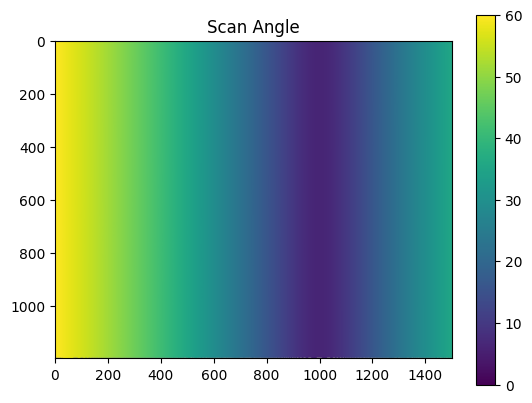

In [31]:
#Scan angles exist on the lower-resolution tiepoint grid (denoted tn): geometry_tn.n
file_geometry_tn = basedir+os.sep+'geometry_tn.nc'
print(file_geometry_tn)

with Dataset(file_geometry_tn) as src: 
    # Each datafile contains multiple bands
    for band, variable in src.variables.items():
        print('------' + band + '------')
        
        if "sat_" in band:
            bandName = band 
            # Printing the attributes of the BT_in variables:
            for attrname in variable.ncattrs():
                print("{} -- {}".format(attrname, getattr(variable, attrname))) 
                exec(bandName + ' = src.variables[bandName][:]')
            print('saveing ' + bandName + ' to variable') 
            print('The shape of ' + bandName + ' is: ' + str(eval(bandName).shape))
            print('The data type of ' + bandName + ' is: ' + str(eval(bandName).dtype))
            print('The min value of ' + bandName + ' is: ' + str(np.min(eval(bandName))))
            print('The max value of ' + bandName + ' is: ' + str(np.max(eval(bandName))))

print('However the shape of the BT data is: ' + str(lon_in.shape))

import scipy.interpolate
from scipy.interpolate import griddata
# the lower-resolution grid is defined by the lat/lon of the tiepoints, in geodetic_tx.nc
data = Dataset(basedir+os.sep+'geodetic_tx.nc')
print('Loading geodetic_tx.nc')
data.set_auto_mask(False)
lat_tx = data.variables['latitude_tx'][:]
lon_tx = data.variables['longitude_tx'][:]
data.close()
print('The shape of lat_tx is: ' + str(lat_tx.shape))
print('The shape of lon_tx is: ' + str(lon_tx.shape))
print('The shape of sat_zenith_tn is: ' + str( sat_zenith_tn.shape))

# Interpolate to the original high-resolution grid:
scanangle_in = griddata((lat_tx.flatten(),lon_tx.flatten()), sat_zenith_tn.flatten(),(lat_in,lon_in), method='linear')

plt.figure()
plt.imshow(scanangle_in, vmin=0, vmax=60)
plt.colorbar()
plt.title('Scan Angle')
plt.show()


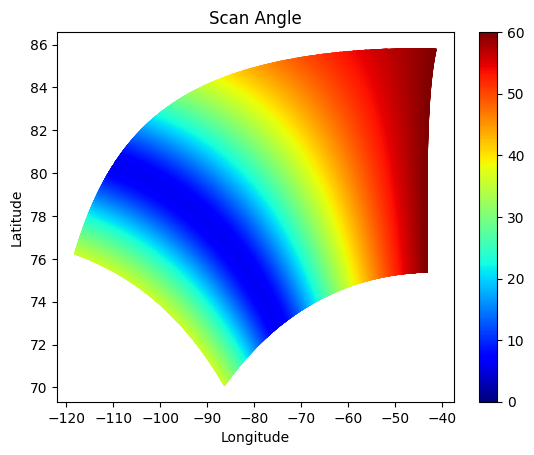

In [32]:
plt.figure()
plt.scatter(lon_in, lat_in, s=0.1, c=scanangle_in.flatten(), cmap='jet', vmin=0, vmax=60)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('Scan Angle')
plt.show()


### Q3: Implement and compare the two algorithms for estimating the IST

When calculating IST12, you need to extract data from part of the nadir view, where we also have coverage by the oblique view. To do this, you may again use the function scipy.interpolate.griddata. The same goes when you need to compare the outcome of the two algorithms. 

In [33]:
print(sat_zenith_tn)


[[60.9707342215542 60.378322129985364 59.7657338643278 ... -- -- --]
 [60.97071534789904 60.37831013706236 59.76572464164651 ... -- -- --]
 [60.97069647424388 60.37829814413934 59.765715418965215 ... -- -- --]
 ...
 [60.965682961776395 60.37285454786246 59.75928171940728 ... -- -- --]
 [60.965696886647365 60.372852133972906 59.7592889547884 ... -- -- --]
 [60.96571081151833 60.37284972008336 59.75929619016953 ... -- -- --]]


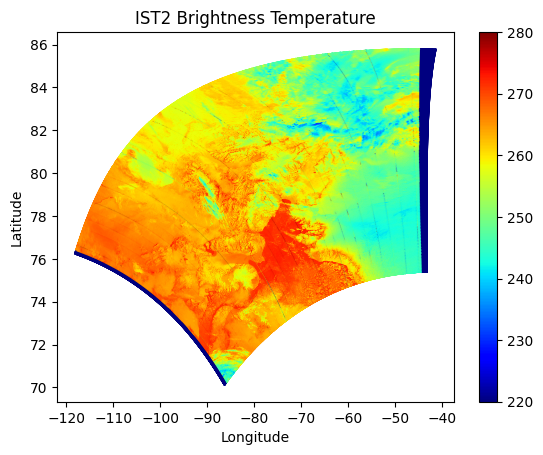

In [46]:
# calculate the first IST algorithm (IST2):
a0 = -0.6384
a1 = 2.444
a2 = -1.442
a3 = -0.0633

IST2 = a0 + a1*s8_BT_n + a2*s9_BT_n + a3*((s8_BT_n - s9_BT_n) * (1/ np.cos(scanangle_in)-1))

plt.figure()
plt.scatter(lon_in, lat_in, s=0.1, c=IST2.flatten(), cmap='jet', vmin=220, vmax=280)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('IST2 Brightness Temperature')
plt.show()


In [43]:
# get oblique geo data:
data = Dataset(basedir+os.sep+'geodetic_io.nc')
data.set_auto_mask(False)
lat_io = data.variables['latitude_io'][:]
lon_io = data.variables['longitude_io'][:]
data.close()

print('The shape of lat_io is: ' + str(lat_io.shape))
print('The shape of lon_io is: ' + str(lon_io.shape))

# interpolate the nadir BT data to the oblique grid:
s8_BT_n_io = griddata((lat_in.flatten(), lon_in.flatten()), s8_BT_n.flatten(), (lat_io, lon_io), method='linear')


The shape of lat_io is: (1200, 900)
The shape of lon_io is: (1200, 900)


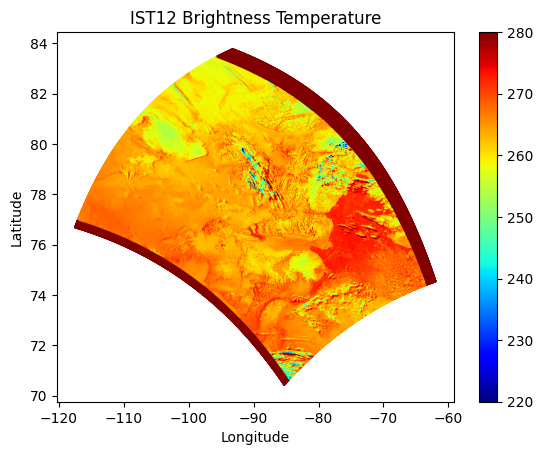

In [44]:
# Calculaate the IST12:
a0 = -0.3952
a1 = 2.3205
a2 = -1.3193

IST12 = a0 + a1*s8_BT_n_io + a2*s8_BT_o

plt.figure()
plt.scatter(lon_io, lat_io, s=0.1, c=IST12.flatten(), cmap='jet', vmin=220, vmax=280)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('IST12 Brightness Temperature')
plt.show()

### Q4: Discuss the pros and cons of the two IST calculations

In [48]:
# Make the IST2 fit on the oblique grid:
IST2_io = griddata((lat_in.flatten(), lon_in.flatten()), IST2.flatten(), (lat_io, lon_io), method='linear')



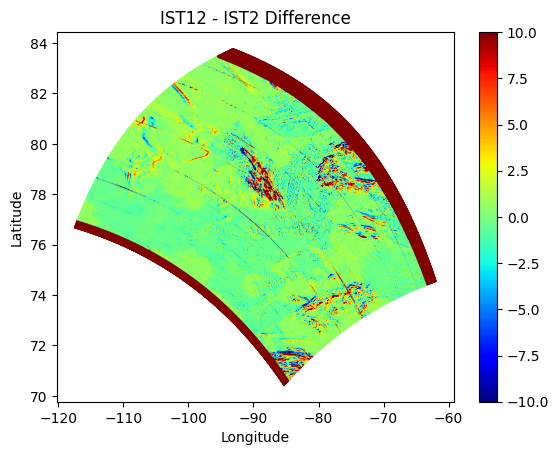

In [49]:
# Calculate the difference between IST12 and IST2:
IST_diff = IST12 - IST2_io

plt.figure()
plt.scatter(lon_io, lat_io, s=0.1, c=IST_diff.flatten(), cmap='jet', vmin=-10, vmax=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('IST12 - IST2 Difference')
plt.show()

### Q5: Discuss the shortcomings of this exercise in terms of properly producing IST maps for this region

You can e.g. refer to the DMI sea ice charts: http://ocean.dmi.dk/arctic/icecharts_gl_1.uk.php